In [ ]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-11-21 06:58:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.207, 173.194.195.207, 173.194.196.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   125MB/s    in 1.3s    

2023-11-21 06:58:39 (125 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)}images in '{dirpath}'.")


There are 2 directories and 0images in '10_food_classes_10_percent'.
There are 10 directories and 0images in '10_food_classes_10_percent/test'.
There are 0 directories and 250images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250images in '10_food_classes_10_percent/test/ramen'

creating data loaders

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


* setting up callbacks(things to run whilst our model trains)
* callbacks-are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

* Experiment tracking with TensorBoard -
* Model checkpointing
* early stopping
** The TensorBoard callback can be accessed using tf.keras.callbacks.TensorBoard().
update_freq='epoch'

In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

* we're going to use two models from TensorFlow Hub:

* ResNetV2 - a state of the art computer vision model architecture from 2016.
* EfficientNet - a state of the art computer vision architecture from 2019.
* state of the art-> at some point both of these models have acheived the lowest error rate
* paperswithcode.com


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.14.0


*  feature vector and not classification?


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-feature-vector/versions/1"
#https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/tensorFlow2/variations/b0-feature-vector/versions/1?tfhub-redirect=true

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhu

* This function will take a model's TensorFlow Hub URL, instatiate a Keras Sequential model with the appropriate number of output layers and return the model.

In [ ]:
def create_model(model_url,num_classes=10):
  """ takes  a tensorflow hub url URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  feature_extractor_layer=hub.KerasLayer(model_url,
                                         trainable=False,
                                         name='feature_extraction_layer',
                                         input_shape=IMAGE_SHAPE+(3,))
  model=tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation='softmax',name='output_layer')
  ])
  return model

Great! Now we've got a function for creating a model, we'll use it to first create a model using the ResNetV250 architecture as our feature extraction layer.

Once the model is instantiated, we'll compile it using categorical_crossentropy as our loss function, the Adam optimizer and accuracy as our metric.

In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])


In [ ]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                          experiment_name="resnet50V2")]) # name of log files



Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20231121-065856
Epoch 1/5
24/24 [==============================] - 29s 714ms/step - loss: 2.0052 - accuracy: 0.3360 - val_loss: 1.2894 - val_accuracy: 0.5716
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 0.9698 - accuracy: 0.7040 - val_loss: 0.8906 - val_accuracy: 0.7056
Epoch 3/5
24/24 [==============================] - 11s 464ms/step - loss: 0.6381 - accuracy: 0.8080 - val_loss: 0.7792 - val_accuracy: 0.7444
Epoch 4/5
24/24 [==============================] - 12s 514ms/step - loss: 0.4868 - accuracy: 0.8760 - val_loss: 0.7154 - val_accuracy: 0.7648
Epoch 5/5
24/24 [==============================] - 13s 543ms/step - loss: 0.3866 - accuracy: 0.9107 - val_loss: 0.7125 - val_accuracy: 0.7600


In [ ]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
   """
  Returns separate loss curves for training and validation metrics.
  """
   loss =history.history['loss']
   val_loss=history.history['val_loss']
   accuracy = history.history['accuracy']
   val_accuracy = history.history['val_accuracy']

   epochs = range(len(history.history['loss']))

   # Plot loss
   plt.plot(epochs, loss, label='training_loss')
   plt.plot(epochs, val_loss, label='val_loss')
   plt.title('Loss')
   plt.xlabel('Epochs')
   plt.legend()

   # Plot accuracy
   plt.figure()
   plt.plot(epochs, accuracy, label='training_accuracy')
   plt.plot(epochs, val_accuracy, label='val_accuracy')
   plt.title('Accuracy')
   plt.xlabel('Epochs')
   plt.legend();


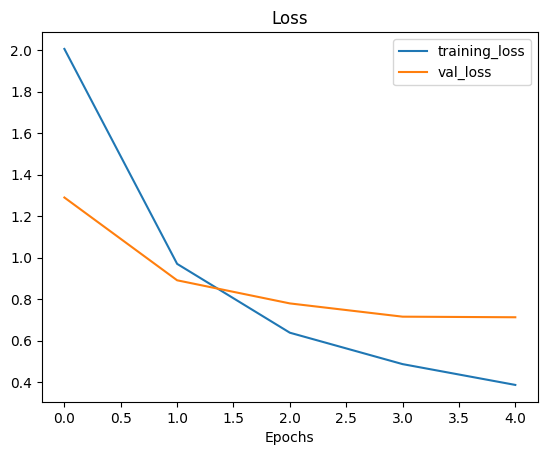

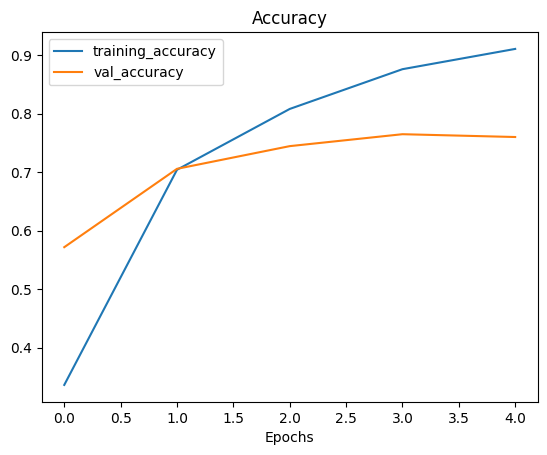

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:

# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                                       # Track logs under different experiment name
                                                                                      experiment_name="efficientnetB0")])




Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20231121-071211
Epoch 1/5
24/24 [==============================] - 24s 518ms/step - loss: 1.8048 - accuracy: 0.4733 - val_loss: 1.2633 - val_accuracy: 0.7364
Epoch 2/5
24/24 [==============================] - 10s 432ms/step - loss: 1.0481 - accuracy: 0.7800 - val_loss: 0.8611 - val_accuracy: 0.8208
Epoch 3/5
24/24 [==============================] - 14s 598ms/step - loss: 0.7535 - accuracy: 0.8493 - val_loss: 0.6974 - val_accuracy: 0.8416
Epoch 4/5
24/24 [==============================] - 16s 661ms/step - loss: 0.6076 - accuracy: 0.8707 - val_loss: 0.6079 - val_accuracy: 0.8544
Epoch 5/5
24/24 [==============================] - 10s 443ms/step - loss: 0.5171 - accuracy: 0.8827 - val_loss: 0.5549 - val_accuracy: 0.8608


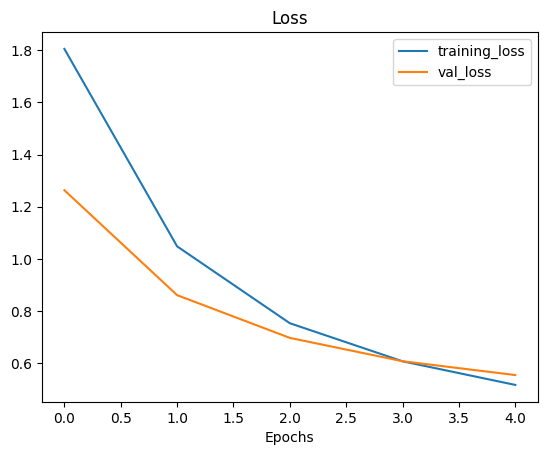

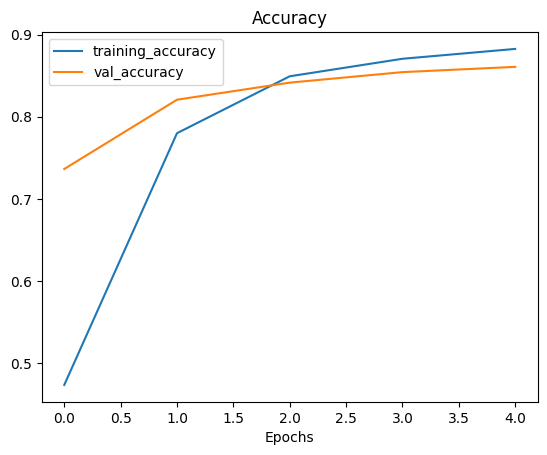

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________
